# Arima Model for stock ratio prediciton

## Packages

In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression



from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from pmdarima.arima.utils import ndiffs

##Removes warning for chained assignments
pd.options.mode.chained_assignment = None  # default='warn'

## Data Import   

In [11]:
df = pd.read_csv('../raw_data/ratios.csv')

,Date,ALB_ZBRA,NRG_CPRT,DE_BXP,NRG_STE,NRG_XRAY,SO_NLOK,PEG_O
0,2020-08-31,0.311845,0.310544,2.548054,0.203834,0.727693,2.136432,0.882281
1,2020-09-01,0.332974,0.306303,2.687319,0.203522,0.722940,2.094566,0.855546
2,2020-09-02,0.332368,0.315056,2.629334,0.204743,0.734758,2.125291,0.872526
3,2020-09-03,0.339772,0.310060,2.534974,0.201707,0.728923,2.210971,0.848504
4,2020-09-04,0.356920,0.300754,2.536138,0.199887,0.707646,2.152835,0.854765
...,...,...,...,...,...,...,...,...
492,2022-08-15,0.813028,0.321488,4.111073,0.197467,1.123670,3.277218,0.920803
493,2022-08-16,0.814154,0.323634,4.118669,0.200499,1.158238,3.283272,0.933379
494,2022-08-17,0.815450,0.327442,4.154118,0.201342,1.191888,3.347435,0.935173
495,2022-08-18,0.816374,0.333768,4.222490,0.204492,1.196920,3.371537,0.950678


### Split Test Data 

Will aim to predict the last 20 days (approximately one month of trading days) so will split data into a train and test set of 477 and 20.

In [33]:
train = df[:477]
test = df[477:]

### Data Examination with  Long ALB vs Short ZBRA

In [34]:
train_alb = train[['Date','ALB_ZBRA']]
test_alb = test[['Date','ALB_ZBRA']]

In [35]:
train_alb.loc[:,('t-1')] = train_alb.loc[:,('ALB_ZBRA')].shift(1)

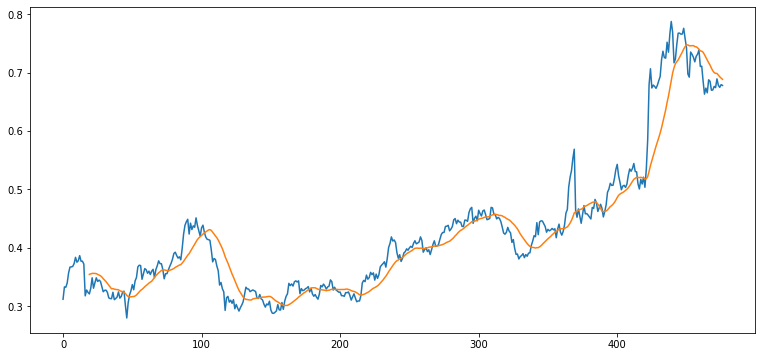

In [36]:
fig , ax1 = plt.subplots(1,1,figsize=(13,6))
ax1.plot(train_alb['ALB_ZBRA']);
ax1.plot(train_alb['ALB_ZBRA'].rolling(20).mean())

First Glance appears to be no seasonality but has a non-constant mean and variance as expected as ratios have been chosen as they exhibit growth. 

In [60]:
adfuller(train_alb['ALB_ZBRA'])[1]

0.8929920533438056

adfuller shows ratio is highly unstationary

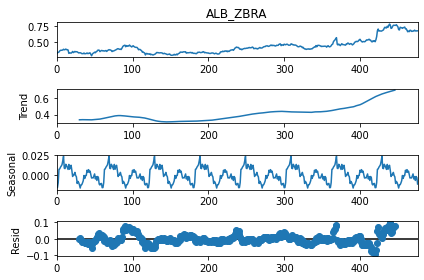

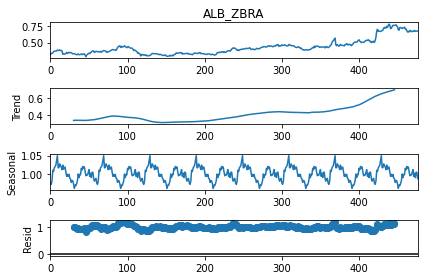

In [51]:
decomp_add = seasonal_decompose(train_alb['ALB_ZBRA'],model='a',period=60)
decomp_add.plot();
decomp_mul = seasonal_decompose(train_alb['ALB_ZBRA'],model='m',period=60)
decomp_mul.plot();


Decomposing actually shows highly seasonal across weekly monthly and three monthly periods

([<matplotlib.lines.Line2D at 0x7f42a57cd8e0>],
 Text(0.5, 1.0, 'Multiplicative Residuals'))

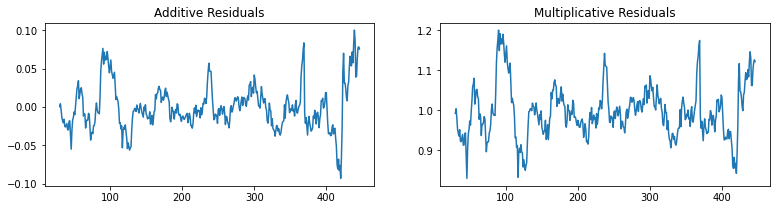

In [53]:
fig , (ax1 , ax2)  = plt.subplots(1,2,figsize=(13,3))
ax1.plot(decomp_add.resid),ax1.set_title('Additive Residuals')
ax2.plot(decomp_mul.resid),ax2.set_title('Multiplicative Residuals')

No Obvious difference between Additive and Multiplicative Residuals check using Adfuller 

In [57]:
print('Raw Data:',adfuller(train_alb['ALB_ZBRA'])[1],
     'Additive:',adfuller(decomp_add.resid.dropna())[1],
     'Multiplicative:',adfuller(decomp_mul.resid.dropna())[1])


Raw Data: 0.8929920533438056 Additive: 0.00011910941875672287 Multiplicative: 0.0002369827799482017


Additive slightly better than multiplicative both way better than raw ratios. Check PACF and ACF 

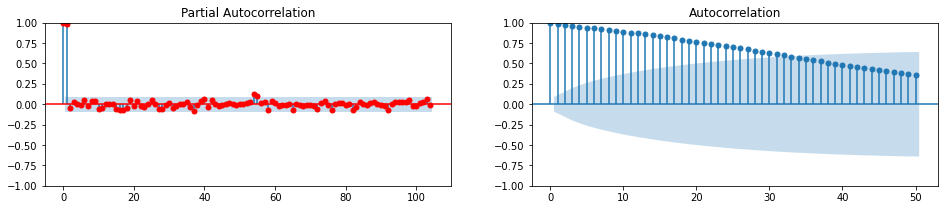

In [65]:
figs , axes = plt.subplots(1,2,figsize = (16,3));
plot_pacf(train_alb['ALB_ZBRA'], lags = 104 , c='r',method='ywm', ax=axes[0]);
plot_acf(train_alb['ALB_ZBRA'], lags=50,ax=axes[1]);

Autocorrelation shows that the further back the day the less impact the day has approximatley only the last 30 days is statistically signifigant.similarly with Partial Autocorrelation not much indication that more than a few of the previous days have an impact on the next days ratio. 

#### Adding differencing to increase stationarity

In [66]:
ndiffs(train_alb['ALB_ZBRA'])

1

In [67]:
# ndiffs suggesting 1 difference
train_alb['Difference'] = train_alb['ALB_ZBRA'].diff()
train_alb.head()

,Date,ALB_ZBRA,t-1,Difference
0,2020-08-31,0.311845,NaN,NaN
1,2020-09-01,0.332974,0.311845,0.021129
2,2020-09-02,0.332368,0.332974,-0.000607
3,2020-09-03,0.339772,0.332368,0.007404
4,2020-09-04,0.356920,0.339772,0.017148


1.852158352130661e-28

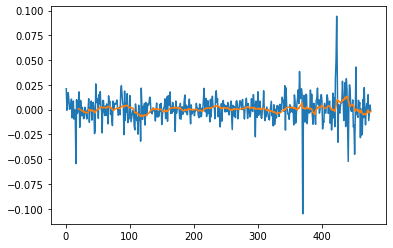

In [74]:
plt.plot(train_alb['Difference'])
plt.plot(train_alb['Difference'].rolling(20).mean())
adfuller(train_alb['Difference'].dropna())[1]

adfuller is very close to zero so ratios difference is much more stationary.

In [77]:
#Remove Seasonality
train_alb['deseasonalised'] = train_alb['ALB_ZBRA']/decomp_mul.seasonal

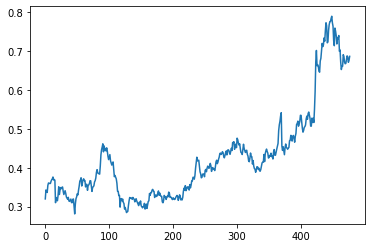

In [79]:
plt.plot(train_alb['deseasonalised'])

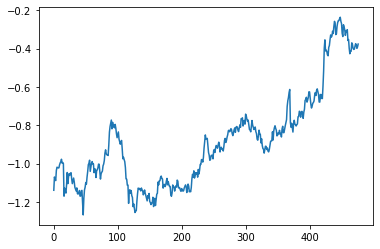

In [80]:
# remove exponential trend
train_alb['linearised'] = np.log(train_alb['deseasonalised'])

plt.plot(train_alb['linearised'])

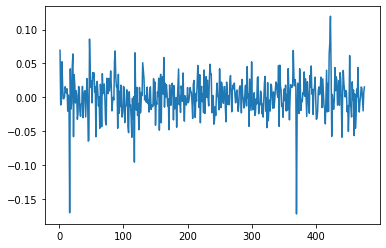

In [82]:
# rerun differencing with linearised data

train_alb['diff_lin'] = train_alb['linearised'].diff()
plt.plot(train_alb['diff_lin'])

In [86]:
#recheck adfuller on new column 
adfuller(train_alb['diff_lin'].dropna())[1]

0.0

/home/sam/.pyenv/versions/3.8.12/envs/long-short-trade-ideas-generator/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


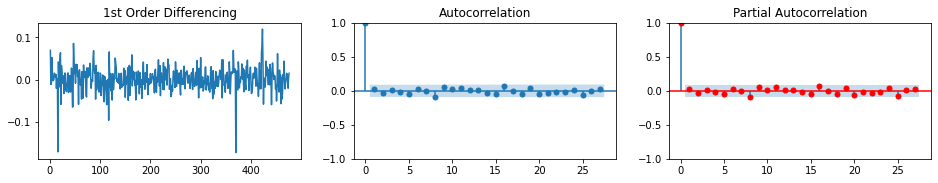

In [88]:
# check ACF and PACF
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(train_alb['diff_lin'].dropna()); axes[0].set_title('1st Order Differencing')
plot_acf(train_alb['diff_lin'].dropna(), ax=axes[1]);
plot_pacf(train_alb['diff_lin'].dropna(), ax=axes[2], c='r');

### Model 

In [92]:
arima = ARIMA(train_alb['linearised'], order = (0,1,0 ),trend='t')
arima = arima.fit()

In [93]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             linearised   No. Observations:                  477
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1025.203
Date:                Tue, 30 Aug 2022   AIC                          -2046.405
Time:                        21:41:50   BIC                          -2038.074
Sample:                             0   HQIC                         -2043.129
                                - 477                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0016      0.001      1.193      0.233      -0.001       0.004
sigma2         0.0008   2.65e-05     29.735      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):               782.45
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.80
Prob(H) (two-sided):                  0.49   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
forecast = arima.forecast(len(test_alb),alpha = 0.05)

In [115]:
train = train_alb['linearised'][0:460]
test = train_alb['linearised'][460:]

arima = ARIMA(train, order = (0,1,0 ),trend='t')
arima = arima.fit()

forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values



In [116]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);


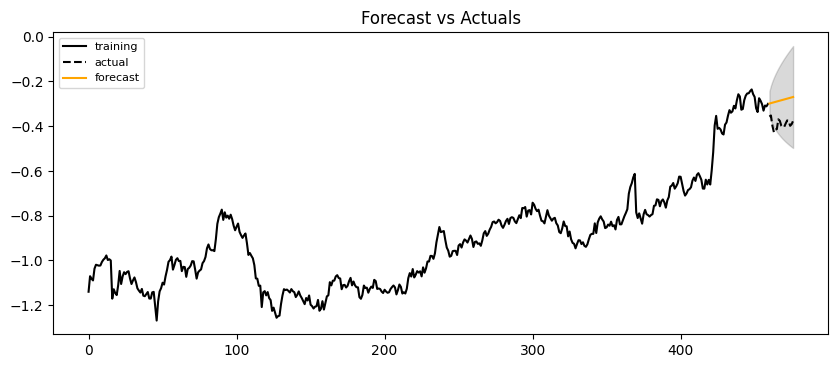

In [117]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

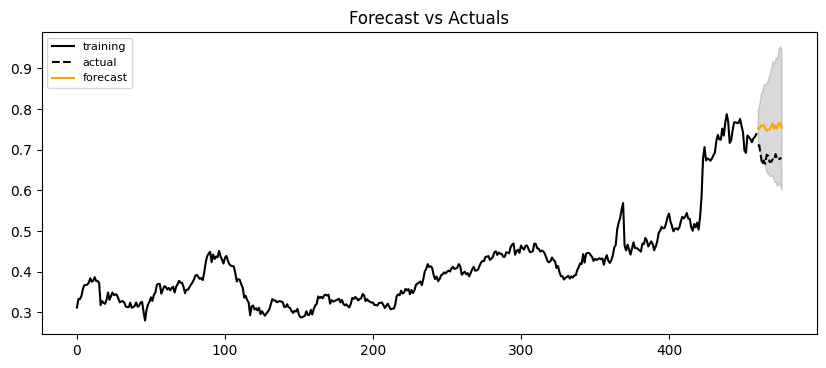

In [118]:
forecast_recons = np.exp(forecast) * decomp_mul.seasonal[460:]
train_recons = np.exp(train) * decomp_mul.seasonal[0:460]
test_recons = np.exp(test) * decomp_mul.seasonal[460:]
lower_recons = np.exp(confidence_int)[:, 0] * decomp_mul.seasonal[460:]
upper_recons = np.exp(confidence_int)[:, 1] * decomp_mul.seasonal[460:]

# Plot
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)